# Alogirtmos Random Forest

## Objetivos
* Analizar las distintas opciones de scikit-learn a la hora de crear algoritmos del tipo Random Forest

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

%load_ext version_information
%version_information numpy, scipy, matplotlib, pandas, scikit-learn

Software versions
Python 3.5.3 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 5.1.0
OS Linux 4.9.16 gentoo x86_64 with debian stretch sid
numpy 1.12.1
scipy 0.19.0
matplotlib 2.0.0
pandas 0.19.2
scikit-learn 0.18.1
Sun Apr 09 18:35:20 2017 UTC

In [21]:
import os
import sys
sys.path.append("../src/")

import pandas as pd
import matplotlib
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit
import ml_plots as mp
from scoring_functions import my_accuracy_scorer
from scoring_functions import my_brier_scorer

pd.options.display.float_format = '{:,.3f}'.format
matplotlib.rcParams.update({'font.size': 12})

In [19]:
SCORES = [(my_accuracy_scorer, 0.5, 1.01), (my_brier_scorer, -0.5, 0.01)]
IN_OPTIONS = ['IN_CR', 'IN_CS', 'IN_DS', 'is_Table', 'is_Columnar', 'is_Int', 'is_Float', 'is_String', 'Type_Size', 'Chunk_Size',
              'Mean', 'Median', 'Sd', 'Skew', 'Kurt', 'Min', 'Max', 'Q1', 'Q3', 'BLZ_CRate', 'BLZ_CSpeed', 'BLZ_DSpeed', 'LZ4_CRate',
              'LZ4_CSpeed', 'LZ4_DSpeed']
OUT_CODEC = ['Blosclz', 'Lz4', 'Lz4hc', 'Snappy', 'Zstd']
OUT_FILTER = ['Noshuffle', 'Shuffle', 'Bitshuffle'] 
OUT_LEVELS = ['CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6', 'CL7', 'CL8', 'CL9']
OUT_BLOCKS = ['Block_8', 'Block_16', 'Block_32', 'Block_64', 'Block_128', 'Block_256', 'Block_512', 'Block_1024', 'Block_2048']
OUT_OPTIONS = OUT_CODEC + OUT_FILTER + OUT_LEVELS + OUT_BLOCKS

In [9]:
df = pd.read_csv('../data/training_data.csv', sep='\t')
X, Y = df[IN_OPTIONS].values, df[OUT_OPTIONS].values

In [10]:
rfc = RandomForestClassifier(n_estimators=50, n_jobs=-1)

## LEARNING CURVES

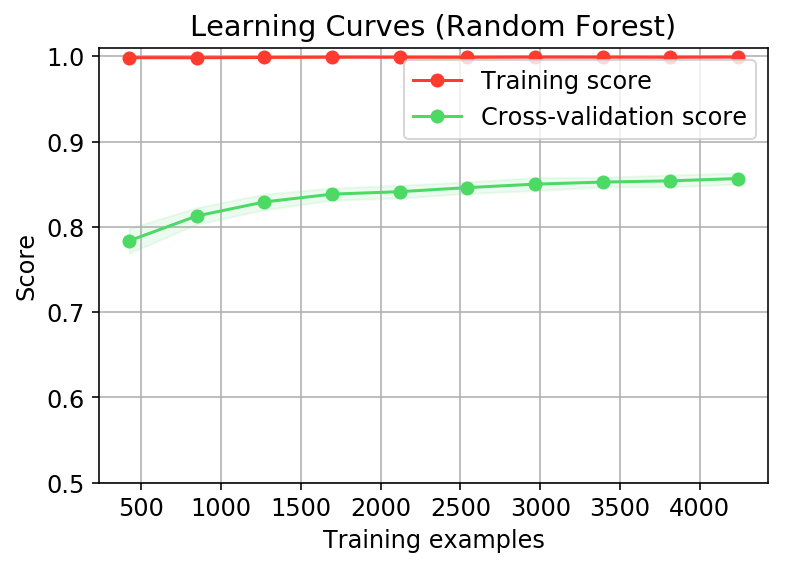

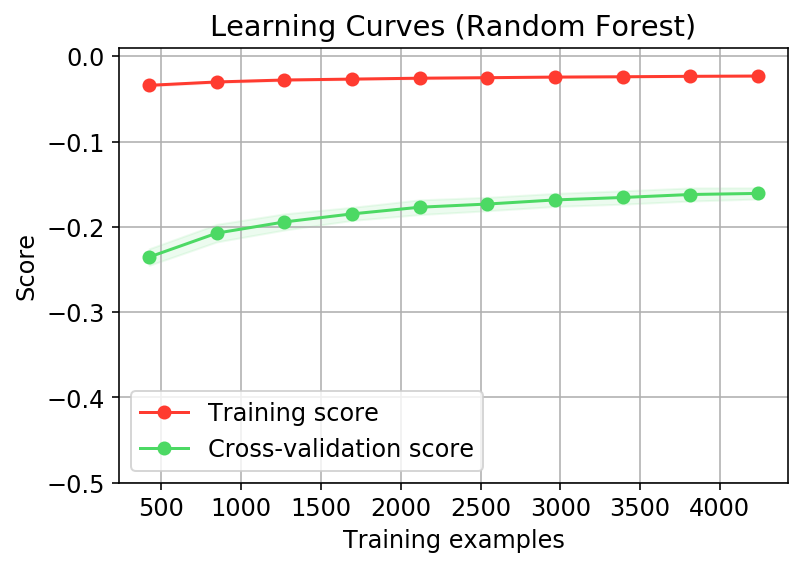

In [20]:
title = "Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=10, test_size=0.1)
for score in SCORES:
    mp.plot_learning_curve(rfc, title, X, Y, scoring=score[0], ylim=(score[1], score[2]), cv=cv, n_jobs=-1,
                       train_sizes=np.linspace(.1, 1.0, 10))

## VALIDATIONS CURVES

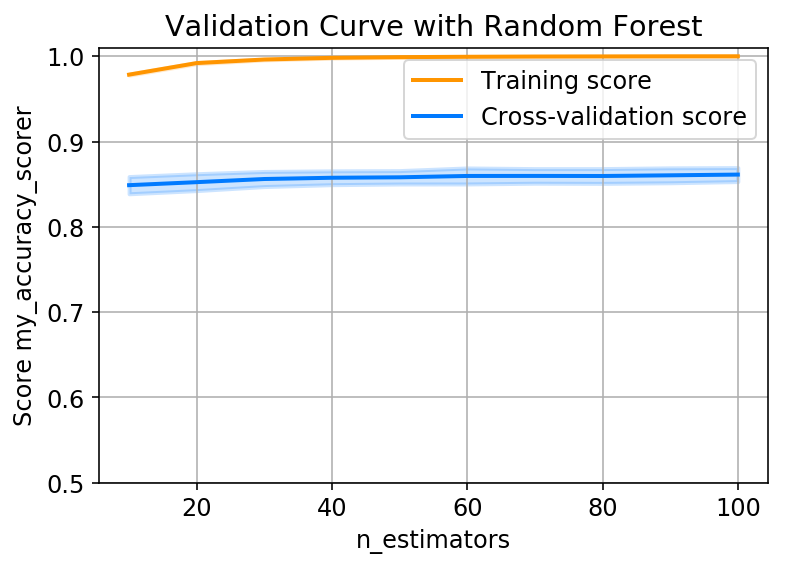

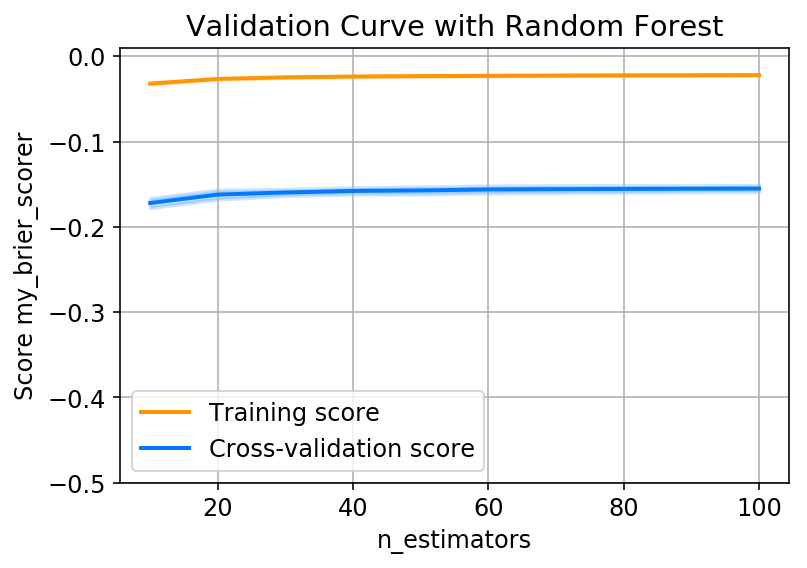

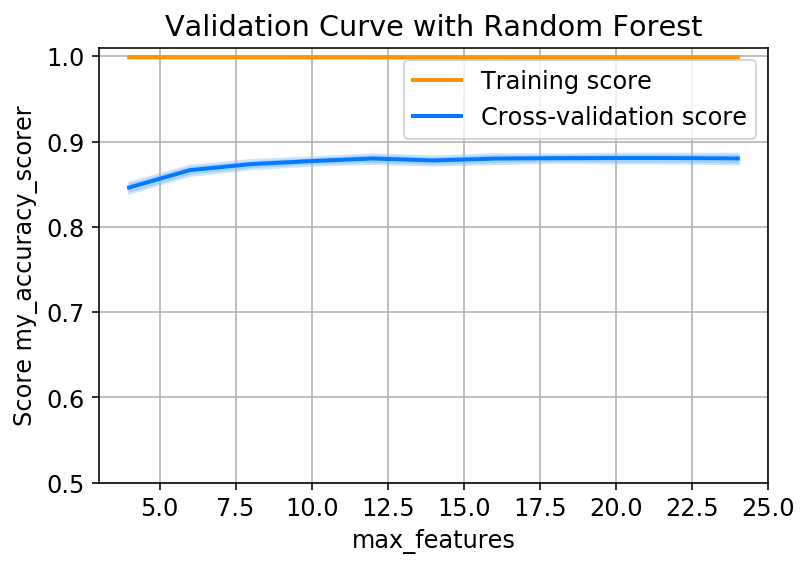

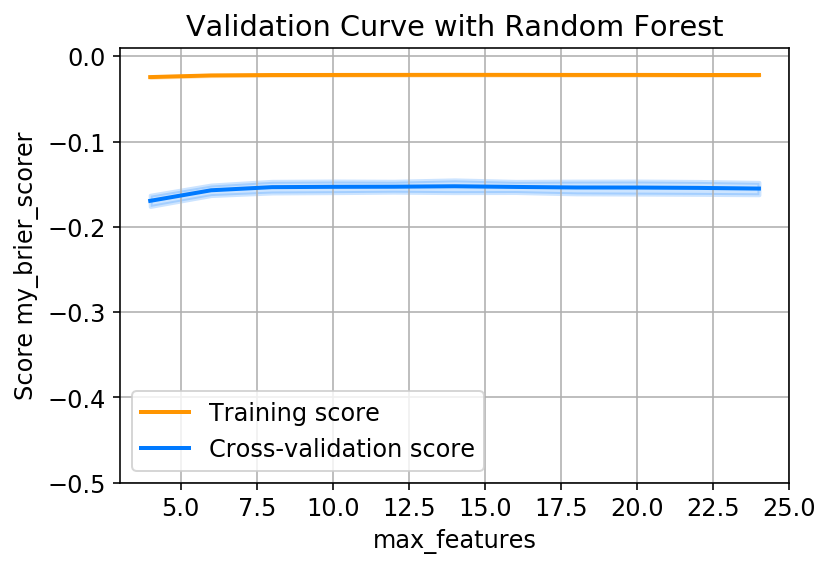

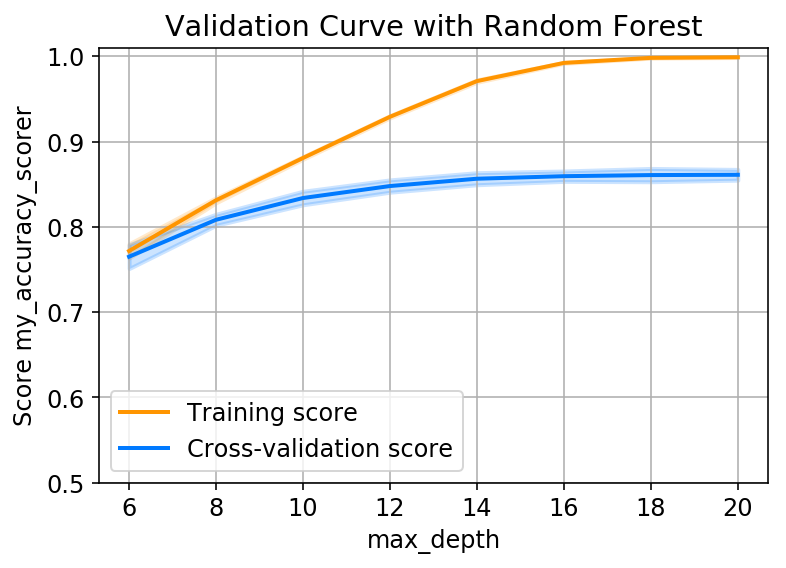

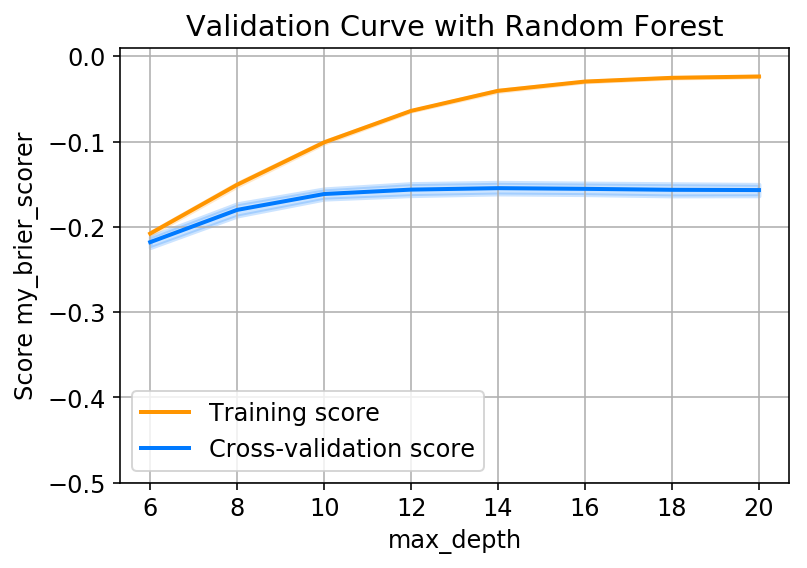

In [25]:
PARAM_NAMES = ['n_estimators', 'max_features', 'max_depth']
PARAM_RANGES = [[10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                [4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24],
                [6, 8, 10, 12, 14, 16, 18, 20]]
for i in range(3):
    for score in SCORES:
        mp.plot_validation_curve(rfc, X, Y, param_name=PARAM_NAMES[i], param_range=PARAM_RANGES[i],
                              cv=cv, scoring=score[0], ylim=(score[1], score[2]))

In [ ]:
PARAM_NAMES = ['n_estimators', 'max_features', 'max_depth']
PARAM_RANGES = [[10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                [8, 10, 12, 14, 16, 18, 20, 22, 24],
                [6, 8, 10, 12, 14, 16, 18, 20]]
for i in range(3):
    for score in SCORES:
        plot_validation_curve(rfc, X, Y, param_name=PARAM_NAMES[i], param_range=PARAM_RANGES[i],
                              cv=cv, scoring=score)

In [ ]:
%%time
count = 0
rfc = RandomForestClassifier(n_estimators=40, max_depth=16, n_jobs=-1)
for score in SCORES:
    non_nested_scores = np.zeros(NUM_TRIALS)
    nested_scores = np.zeros(NUM_TRIALS)
    estimators_valid_curves = []
    features_valid_curves = []
    depth_valid_curves = []
    estimators = []
    print('Starting with ' + str(score))
    for i in range(NUM_TRIALS):
        print(str(score) + ' trial number ' + str(i))
        inner_cv = ShuffleSplit(n_splits=10, test_size=0.25)
        outer_cv = ShuffleSplit(n_splits=10, test_size=0.25)
        
        clf = GridSearchCV(estimator=rfc, param_grid=p_grid, cv=inner_cv, n_jobs=-1, scoring=score)
        clf.fit(X, Y)
        non_nested_scores[i] = clf.best_score_
        count += 1
        print('Non nested scores completed -------------- %.2f %%' % (count / 180))
        
        nested_score = cross_val_score(clf, X=X, y=Y, cv=outer_cv, scoring=score, n_jobs=1)
        nested_scores[i] = nested_score.mean()
        count += 1
        print('Nested scores completed ------------------ %.2f %%' % (count / 180))
        estimators.append(clf.best_estimator_)
    all_non_nested_scores.append(non_nested_scores)
    all_nested_scores.append(nested_scores)
    all_estimators.append(estimators)
joblib.dump(all_non_nested_scores, 'Non_nested_scores.pkl')
joblib.dump(all_nested_scores, 'Nested_scores.pkl')
joblib.dump(all_estimators, 'Estimators.pkl')

In [ ]:
for non_nested_scores, nested_scores in (all_non_nested_scores, all_nested_scores):
    score_difference = non_nested_scores - nested_scores

    print("Average difference of {0:6f} with std. dev. of {1:6f}."
          .format(score_difference.mean(), score_difference.std()))

    # Plot scores on each trial for nested and non-nested CV
    plt.figure()
    plt.subplot(211)
    non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
    nested_line, = plt.plot(nested_scores, color='b')
    plt.ylabel("score", fontsize="14")
    plt.legend([non_nested_scores_line, nested_line],
               ["Non-Nested CV", "Nested CV"],
               bbox_to_anchor=(0, .4, .5, 0))
    plt.title("Non-Nested and Nested Cross Validation on Iris Dataset",
              x=.5, y=1.1, fontsize="15")

    # Plot bar chart of the difference.
    plt.subplot(212)
    difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
    plt.xlabel("Individual Trial #")
    plt.legend([difference_plot],
               ["Non-Nested CV - Nested CV Score"],
               bbox_to_anchor=(0, 1, .8, 0))
    plt.ylabel("score difference", fontsize="14")

    plt.show()